In [88]:
import os 
import string 
import matplotlib.pyplot as plt 
import numpy as np
import string 
import torch
import torch.nn as nn 
import os,random,time,math
from tqdm import tqdm
from IPython.display import clear_output

In [29]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [30]:
language=[]
data=[]
x=[]
y=[]
file_path='/kaggle/input/rnn-files/rnn.txt'
with open(file_path,'r') as f:
    for line in tqdm(f):
        line=line.split(',')
        name=line[0].strip()
        lang=line[1].strip()
        if not lang in language:
            language.append(lang)
        x.append(name)
        y.append(lang)
        data.append((name,lang))
n_language=len(language)
n_language

20050it [00:00, 568506.77it/s]


18

In [31]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [32]:
all_letters=string.ascii_letters+" .,;'"
n_letters=len(all_letters)
n_letters

57

In [33]:
def name_rep(name):
    rep=torch.zeros(len(name),1,n_letters)
    for index,letter in enumerate(name):
        pos=all_letters.find(letter)
        rep[index][0][pos]=1
    return rep

In [34]:
def lang_rep(lang):
    return torch.tensor([language.index(lang)],dtype=torch.long)


In [35]:
count={}
for l in tqdm(language):
    count[l]=0
for d in tqdm(data):
    count[d[1]]+=1

100%|██████████| 20050/20050 [00:00<00:00, 1589983.08it/s]


In [63]:
class RNN_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return torch.zeros(1, batch_size, self.hidden_size)

In [65]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_language)

In [66]:
def infer(net, name, device = 'cpu'):
    name_ohe = name_rep(name).to(device)
    
    output, hidden = net(name_ohe)
        
    if type(hidden) is tuple: # For LSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)
    
    return output

In [67]:
infer(net, 'Adam')

tensor([[-2.8605, -2.8584, -3.0665, -2.9061, -2.8497, -3.0807, -2.7761, -2.8970,
         -2.8730, -2.8796, -2.9670, -2.8552, -2.8523, -2.9376, -2.7461, -2.8714,
         -2.8946, -2.9121]], grad_fn=<LogSoftmaxBackward0>)

In [68]:
def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    return to_ret

In [69]:
def eval(net, n_points, topk, X_, y_, device = 'cpu'):
    net = net.eval().to(device)
    data_ = dataloader(n_points, X_, y_)
    correct = 0
    
    for name, language, name_ohe, lang_rep in data_:
        
        output = infer(net, name, device)
        val, indices = output.topk(topk)
        indices = indices.to('cpu')
        
        if lang_rep in indices:
            correct += 1
            
    accuracy = correct/n_points
    return accuracy

In [70]:
def batched_name_rep(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

In [71]:
def print_char(name_reps):
    name_reps = name_reps.view((-1, name_reps.size()[-1]))
    for t in name_reps: 
        if torch.sum(t) == 0:
            print('<pad>')
        else:
            index = t.argmax()
            print(all_letters[index])

In [72]:
out_ = batched_name_rep(['Shyam', 'Ram'], 5)
print(out_)
print(out_.shape)
print_char(out_)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0

In [73]:
def batched_dataloader(npoints, X_, y_, verbose=False, device = 'cpu'):
    names = []
    langs = []
    X_lengths = []
    
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)
    
    names_rep = batched_name_rep(names, max_length).to(device)
    langs_rep = batched_lang_rep(langs).to(device)
    
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted = False)
    
    if verbose:
        print(names_rep.shape, padded_names_rep.data.shape)
        print('--')
    
    if verbose:
        print(names)
        print_char(names_rep)
        print('--')
    
    if verbose:
        print_char(padded_names_rep.data)
        print('Lang Rep', langs_rep.data)
        print('Batch sizes', padded_names_rep.batch_sizes)
    
    
    return padded_names_rep.to(device), langs_rep

In [74]:
p, l = batched_dataloader(3, X_train, y_train, True,device)

torch.Size([11, 3, 57]) torch.Size([25, 57])
--
['Averitchkin', 'Armati', 'Ashikaga']
A
A
A
v
r
s
e
m
h
r
a
i
i
t
k
t
i
a
c
<pad>
g
h
<pad>
a
k
<pad>
<pad>
i
<pad>
<pad>
n
<pad>
<pad>
--
A
A
A
v
s
r
e
h
m
r
i
a
i
k
t
t
a
i
c
g
h
a
k
i
n
Lang Rep tensor([13, 17,  8], device='cuda:0')
Batch sizes tensor([3, 3, 3, 3, 3, 3, 2, 2, 1, 1, 1])


In [75]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    total_loss = 0
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i:i+1], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
    return total_loss/n_points

In [76]:
def train_batch(net, opt, criterion, n_points, device = 'cpu'):
    
    net.train().to(device)
    opt.zero_grad()
    
    batch_input, batch_groundtruth = batched_dataloader(n_points, X_train, y_train, False, device)
    
    output, hidden = net(batch_input)
    
    loss = criterion(output, batch_groundtruth)
    
    loss.backward()
    opt.step()
    return loss

In [82]:
import torch.optim as optim
net = RNN_net(n_letters, n_hidden, n_language)
criterion = nn.NLLLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [83]:
%%time 
train(net, opt, criterion, 256)

CPU times: user 468 ms, sys: 15.5 ms, total: 484 ms
Wall time: 483 ms


tensor(2.8419, grad_fn=<DivBackward0>)

In [84]:
net = RNN_net(n_letters, n_hidden, n_language)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [85]:
%%time 
train_batch(net, opt, criterion, 256)

CPU times: user 26.1 ms, sys: 6.87 ms, total: 33 ms
Wall time: 45.9 ms


tensor(2.8922, grad_fn=<NllLossBackward0>)

In [108]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure(figsize=(20,5))
            plt.plot(loss_arr[1:i], '-',color='r',marker='o',mfc='g')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    print('Top-1:', eval(net, len(X_test), 1, X_test, y_test, device), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test, device))
                      

Iteration 4999 Loss 0.44112545251846313


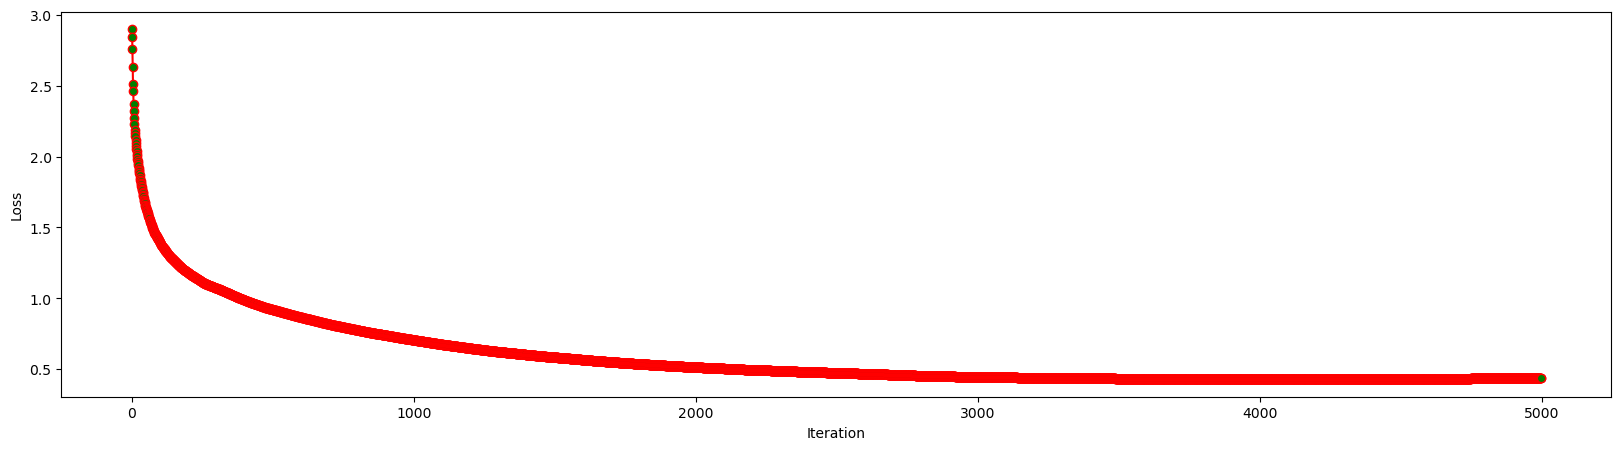




Top-1: 0.7653366583541147 Top-2: 0.8693266832917705
CPU times: user 2min 48s, sys: 4.27 s, total: 2min 52s
Wall time: 2min 47s


In [109]:
%%time
net = RNN_net(n_letters, 128, n_language)
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=100, device = device) # GPU Training Example